In [2]:
import sys
sys.path.insert(0,'../src')
from v0 import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import fiona
import geopandas as gpd

In [2]:
STREET_SHAPE_FOLDER = '/home/adelsondias/Downloads/newcastle_streets/'
LSOA_SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_30days/'

## Street shape

In [3]:
lines = gpd.read_file(STREET_SHAPE_FOLDER+'newcastle_streets.shp')
points = gpd.read_file(STREET_SHAPE_FOLDER+'newcastle_points.shp')

In [4]:
print(lines.columns.values)
print(points.columns.values)

['osm_id' 'name' 'highway' 'waterway' 'aerialway' 'barrier' 'man_made'
 'z_order' 'other_tags' 'geometry']
['osm_id' 'name' 'barrier' 'highway' 'ref' 'address' 'is_in' 'place'
 'man_made' 'other_tags' 'geometry']


In [5]:
lines = lines[(lines['highway']!='') & (lines['highway']!='unclassified')]
lines['highway'].value_counts()

residential       7608
service           4673
footway           4599
tertiary           620
primary            565
cycleway           495
secondary          393
steps              336
path               326
trunk              261
pedestrian         228
track              220
trunk_link         148
bridleway           84
living_street       58
construction        57
primary_link        47
motorway_link       32
secondary_link      30
motorway            29
road                18
tertiary_link       16
Name: highway, dtype: int64

In [6]:
points = points[points['highway']!='']
points['highway'].value_counts().head(10)

bus_stop             2330
traffic_signals       411
crossing              328
turning_circle        169
mini_roundabout       143
street_lamp            30
give_way               26
motorway_junction      17
elevator               12
speed_camera            2
Name: highway, dtype: int64

## LSOA shape

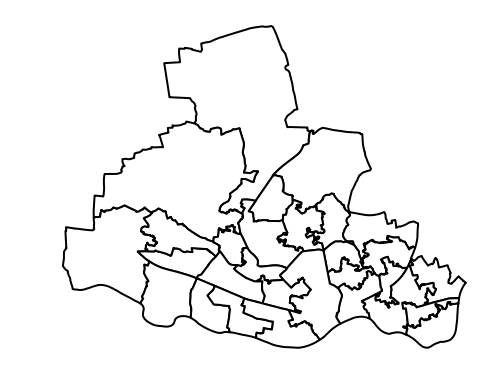

In [8]:
lsoa = gpd.read_file(LSOA_SHAPE_FOLDER+'Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}
newcastle = gpd.GeoSeries(shapely.ops.cascaded_union(lsoa['geometry']))

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5.5))
lsoa.plot(ax=axes,color='white', edgecolor='black',linewidth=2)

# newcastle.plot(ax=axes,color='white', edgecolor='black',linewidth=2)
plt.axis('off')
# plt.title('Newcastle upon Tyne: Middle Layer Super Output Area')
plt.tight_layout()
if False:
    plt.savefig(DATA_FOLDER+'plots/middlelsoa_newcastle.svg', format='svg', dpi=600)

Filtering lines and points within LSOA of Newcastle Upon Tyne

In [9]:
lines = gpd.sjoin(lines, gpd.GeoDataFrame(geometry=newcastle), how='inner' ,op='intersects')[lines.columns]
points = gpd.sjoin(points, gpd.GeoDataFrame(geometry=newcastle), how='inner' ,op='intersects')[points.columns]

In [10]:
lines.head()

,osm_id,name,highway,waterway,aerialway,barrier,man_made,z_order,other_tags,geometry
0,2526644,,cycleway,,,,,0,"""bicycle""=>""yes"",""foot""=>""yes"",""lit""=>""yes"",""s...","LINESTRING (-1.646213 54.9613772, -1.6433333 5..."
6,2534525,Leazes Terrace,residential,,,,,3,,"LINESTRING (-1.6204976 54.9757812, -1.621954 5..."
7,2534565,,cycleway,,,,,0,"""foot""=>""yes""","LINESTRING (-1.6012615 54.9984504, -1.6011195 ..."
8,2534566,,footway,,,,,0,,"LINESTRING (-1.5953468 54.9925473, -1.595381 5..."
10,2534653,Akenside Terrace,residential,,,,,3,"""source:name""=>""OS_OpenData_Locator""","LINESTRING (-1.5998751 54.984268, -1.6012944 5..."


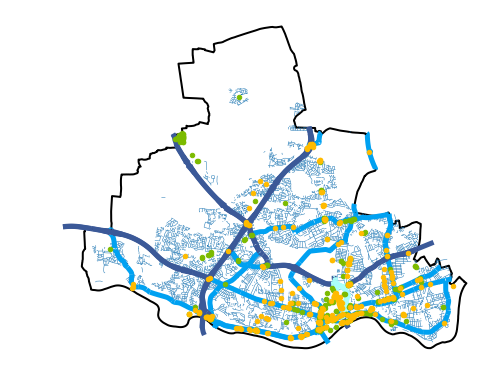

In [11]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5.5))

newcastle.plot(ax=axes,color='white', edgecolor='black',linewidth=2)
lines.loc[lines['highway']=='residential'].plot(ax=axes,linewidth=0.5)
lines.loc[(lines['highway']=='primary') | (lines['highway']=='primary_link')].plot(ax=axes,color='#00A1F1', linewidth=5)
lines.loc[(lines['highway']=='trunk') | (lines['highway']=='trunk_link')].plot(ax=axes,color='#3B5998', linewidth=5)
lines.loc[(lines['highway']=='motorway') | (lines['highway']=='motorway_link')].plot(ax=axes,color='#aafffa', linewidth=5)#color='#7ed02d')

points.loc[points['highway']=='traffic_signals'].plot(ax=axes, color='#FFBB00', markersize=20, zorder=10)
points.loc[points['highway']=='crossing'].plot(ax=axes, color='#7CBB00', markersize=20, zorder=9)

plt.axis('off')
# plt.title('OpenStreetMaps objects of Newcastle upon Tyne')
plt.tight_layout()
if False:
    plt.savefig(DATA_FOLDER+'plots/newcastle_OSMobjects.svg', format='svg', dpi=600)

## Sensors data

In [12]:
metadata = pd.read_csv(DATA_FOLDER+'sensors.csv')

# spatial parsing - geometry column
metadata = gpd.GeoDataFrame(metadata[['name','type','active','lon','lat']],
                        geometry=[shapely.geometry.Point(xy) for xy in zip(metadata['lon'], metadata['lat'])], 
                        crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))

metadata = gpd.sjoin(metadata, lsoa, how='inner' ,op='intersects')[['name','type','active','lon','lat','geometry']]
metadata = metadata.set_index('name')
print(metadata.shape)
metadata.head()

(281, 5)


,type,active,lon,lat,geometry
name,,,,,
new_new_emote_2602,Air Quality,True,-1.618485,54.977193,POINT (-1.618485 54.97719300000001)
eml_sensors_171702,Weather,True,-1.623670,54.972659,POINT (-1.62367 54.972659)
BMS_Armstrong.Armstrong;KRBlrOATTrndOATTKinG (OAT King George Trend_MOM),Environmental,True,-1.617460,54.978180,POINT (-1.61746 54.97818)
new_new_emote_1902,Air Quality,True,-1.621543,54.973455,POINT (-1.62154347697917 54.9734549487624)
new_new_emote_1908,Air Quality,True,-1.623102,54.972139,POINT (-1.62310237397882 54.9721388049708)


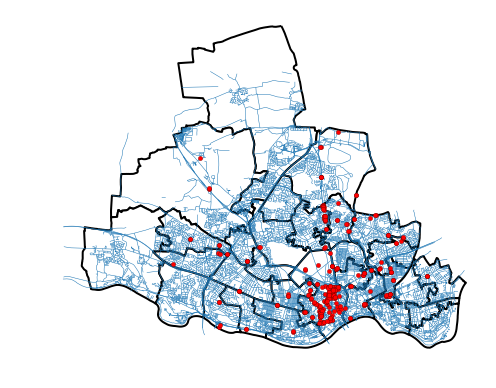

In [13]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5.5))

lsoa.plot(ax=axes,color='white', edgecolor='black',linewidth=2)
lines.plot(ax=axes,linewidth=0.5)
metadata.plot(ax=axes, color='red',edgecolor='black',linewidth=0.2,markersize=20,zorder=10)

plt.axis('off')
plt.tight_layout()
if False:
    plt.savefig(DATA_FOLDER+'plots/newcastle_sensors.svg', format='svg', dpi=600)

## Spatial features extraction

In [14]:
osm_df = osm_features(STREET_SHAPE_FOLDER, LSOA_SHAPE_FOLDER, metadata, 
                     conf={
                         'method':'distance', 
                         'lines':['primary','trunk','motorway','residential'], 
                         'points':['traffic_signals','crossing']}
)

In [24]:
# osm_df.to_csv(DATA_FOLDER+'street_features_newcastle.csv')
osm_df.head()

,primary,trunk,motorway,residential,traffic_signals,crossing
new_new_emote_2602,225.717038,176.034687,158.168053,14978.857286,332.048433,8748.892994
eml_sensors_171702,792.636134,90.258667,77.092709,567.786100,886.980140,777.486146
BMS_Armstrong.Armstrong;KRBlrOATTrndOATTKinG (OAT King George Trend_MOM),171.268788,216.250195,200.024000,1692.565624,384.710844,694.183584
new_new_emote_1902,29231.283686,101.760783,90.177730,647.791622,3354.223106,22125.309242
new_new_emote_1908,1741.911422,87.445773,76.632429,595.704240,1857.718698,1396.863499


(1, 15)

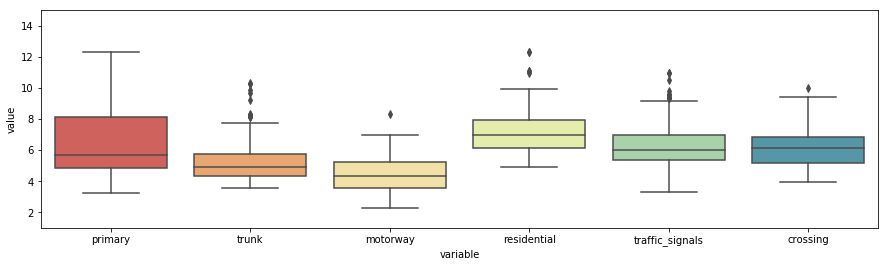

In [72]:
melt = osm_df.melt()
melt['value'] = np.log(melt['value'])
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(15,4));
sns.boxplot(x='variable',y='value',data=melt, ax=axes, palette='Spectral')
axes.set_ylim([1,15])

In [86]:
q = osm_df.quantile(0.5)
# q.to_csv(DATA_FOLDER+'osm_medians.csv')
print(q)
excluded = osm_df.loc[(osm_df['primary']<q['primary']) & (osm_df['trunk']<q['trunk']) & (osm_df['motorway']<q['motorway']) &
           (osm_df['residential']<q['residential']) & (osm_df['traffic_signals']<q['traffic_signals']) &
           (osm_df['crossing']<q['crossing'])]
excluded

primary             303.474144
trunk               134.091405
motorway             74.691421
residential        1072.163710
traffic_signals     402.514674
crossing            468.069923
Name: 0.5, dtype: float64


,primary,trunk,motorway,residential,traffic_signals,crossing
CAJT_NTA1056_IPK2B_SL2,95.169964,58.440947,17.676729,132.781128,64.224914,63.487224
beehive_9848,281.078346,34.373781,28.252633,177.220584,68.172091,109.689346
beehive_54510,281.078346,34.373781,28.252633,177.220584,68.172091,109.689346
beehive_5447,229.982527,100.536469,13.810812,686.061029,148.629851,124.803065
beehive_9850,229.982527,100.536469,13.810812,686.061029,148.629851,124.803065


In [1]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5.5))

lsoa.plot(ax=axes,color='white', edgecolor='black',linewidth=2)
lines.plot(ax=axes,linewidth=0.5)
metadata.plot(ax=axes, color='red',edgecolor='black',linewidth=0.2,markersize=20,zorder=10)
metadata.loc[excluded.index].plot(ax=axes, color='white',edgecolor='black',linewidth=0.2,markersize=30,zorder=15)

plt.axis('off')
plt.tight_layout()
if True:
    plt.savefig(DATA_FOLDER+'plots/newcastle_sensors.svg', format='svg', dpi=600)

NameError: name 'plt' is not defined

In [96]:
def meshgrid(dimensions, lon_range, lat_range, SHAPE=None):
    lon = np.linspace(lon_range[0],lon_range[1], dimensions[0])
    lat = np.linspace(lat_range[0],lat_range[1], dimensions[1])
    lonv, latv = np.meshgrid(lon,lat)
    grid = np.vstack([lonv.ravel(), latv.ravel()]).T
    grid = gpd.GeoDataFrame(grid, geometry=[shapely.geometry.Point(xy) for xy in grid],crs={'init': 'epsg:4326'})
    grid.rename(columns={0:'lon',1:'lat'}, inplace=True)
    if SHAPE is not None:
        grid = gpd.sjoin(grid, gpd.GeoDataFrame(geometry=SHAPE), how='inner', op='intersects')[grid.columns]
    return lonv, latv, grid

lo, la, mesh = meshgrid([50,50],[-1.8, -1.5],[54.95, 55.08], newcastle)

,lon,lat,geometry
225,-1.646939,54.960612,POINT (-1.646938775510204 54.96061224489796)
226,-1.640816,54.960612,POINT (-1.640816326530612 54.96061224489796)
227,-1.634694,54.960612,POINT (-1.63469387755102 54.96061224489796)
228,-1.628571,54.960612,POINT (-1.628571428571429 54.96061224489796)
240,-1.555102,54.960612,POINT (-1.555102040816327 54.96061224489796)


In [98]:
osm_df2 = osm_features(STREET_SHAPE_FOLDER, LSOA_SHAPE_FOLDER, mesh, 
                     conf={
                         'method':'distance', 
                         'lines':['primary','trunk','motorway','residential'], 
                         'points':['traffic_signals','crossing']}
)
osm_df2.head()

,primary,trunk,motorway,residential,traffic_signals,crossing
225,391.853272,34.311356,26.041052,210.874354,193.277120,118.716735
226,461.882409,36.476274,29.767130,256.308157,442.493052,113.357549
227,379.120962,39.048322,35.798693,300.660188,378.431506,89.100239
228,263.875898,44.331872,44.799565,218.984043,244.369443,158.655339
240,236.886081,28.166703,18.887146,696.685258,71.459377,65.800865


In [99]:
excluded2 = osm_df2.loc[(osm_df2['primary']<q['primary']) & (osm_df2['trunk']<q['trunk']) & (osm_df2['motorway']<q['motorway']) &
           (osm_df2['residential']<q['residential']) & (osm_df2['traffic_signals']<q['traffic_signals']) &
           (osm_df2['crossing']<q['crossing'])]
excluded2.head()

,primary,trunk,motorway,residential,traffic_signals,crossing
228,263.875898,44.331872,44.799565,218.984043,244.369443,158.655339
240,236.886081,28.166703,18.887146,696.685258,71.459377,65.800865
241,200.460494,26.983034,17.016316,656.457757,104.753199,68.735676
292,197.297012,27.861976,15.628500,288.430683,192.462546,91.171167
343,154.293538,28.462543,14.398827,259.100322,138.797360,92.519068


In [122]:
mesh.loc[[i for i in mesh.index.values if i not in excluded2.index.values]].to_csv(DATA_FOLDER+'mesh_valid-regions.csv')

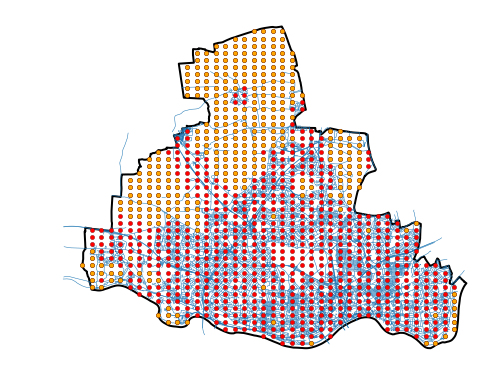

In [109]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5.5))

newcastle.plot(ax=axes,color='white', edgecolor='black',linewidth=2)
lines.plot(ax=axes,linewidth=0.5)
mesh.plot(ax=axes, color='red',edgecolor='black',linewidth=0.2,markersize=20,zorder=10)
mesh.loc[excluded2.index].plot(ax=axes, color='orange',edgecolor='black',linewidth=0.2,markersize=20,zorder=15)

plt.axis('off')
plt.tight_layout()
if True:
    plt.savefig(DATA_FOLDER+'plots/newcastle_valid-regions.svg', format='svg', dpi=600)